<a href="https://colab.research.google.com/github/rikunemu/colab_study/blob/main/pose_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  mediapipeで取ったposeの特徴点を分析

90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,600000)

  
10分ごとに接続

参考url:
https://sunnyday-travel-aso-6487.ssl-lolipop.jp/programing/python/keras/lstm-use/

In [1]:
import sys
from google.colab import drive
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
import os
import keras
from keras import models
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
drive.mount("/content/drive")

Mounted at /content/drive


## csvデータ読み込み
train,test,validそれぞれ7感情の特徴点を記録

In [2]:
fp_train='/content/drive/MyDrive/data分析/join_csv/csvtrainresult.csv'
df_train=pd.read_csv(fp_train)
fp_test='/content/drive/MyDrive/data分析/join_csv/csvtestresult.csv'
df_test=pd.read_csv(fp_test)

Unnameはいらないので削除

In [3]:
df_test=df_test.replace('NAN',0.1)
df_train=df_train.replace('NAN',0.1)

In [4]:
df_train=df_train.drop(columns=df_train.columns[[0]],axis=1)

In [5]:
df_test=df_test.drop(columns=df_test.columns[[0]],axis=1)

In [6]:
df_train=df_train.fillna(0.1)
df_test=df_test.fillna(0.1)

それぞれのデータを目的変数と説明変数に分ける

In [7]:
x_train=DataFrame(df_train.drop("correct",axis=1)).values
Y_train=DataFrame(df_train["correct"]-1).values
x_test=DataFrame(df_test.drop("correct",axis=1)).values
Y_test=DataFrame(df_test["correct"]-1).values

X_test = np.array(x_test).reshape(200, 30,162)
Y_test = np.array(Y_test[::30]).reshape(200)
y_test = np_utils.to_categorical(Y_test,20)
y_test = y_test.astype(np.float)
X_test = X_test.astype(np.float)

In [8]:
def build_model(maxlen):
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, activation='relu', input_shape=(30,maxlen)))
  #model.add(Dropout(0.1))
  #model.add(LSTM(128, return_sequences=True, activation='relu'))
  #model.add(Dropout(0.1))
  #model.add(LSTM(64, return_sequences=False, activation='relu'))
  #model.add(Dropout(0.1))
  #model.add(Dense(64, activation='relu'))
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(20, activation='softmax'))
  adam = Adam(learning_rate=1e-4)
  model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()
    plt.close()

In [10]:
def cmd_pose(Y_test,y_pred):
  cm = confusion_matrix(Y_test, y_pred)
  #表示
  cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  fig, ax = plt.subplots(figsize=(10, 10))
  cmd.plot(ax=ax, cmap="Blues")
  plt.show()
  plt.close()
  return

fold 0 score: [0.92714524269104, 0.8149999976158142]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.80      0.80      0.80        10
           2       0.88      0.70      0.78        10
           3       0.75      0.90      0.82        10
           4       0.91      1.00      0.95        10
           5       0.75      0.30      0.43        10
           6       0.82      0.90      0.86        10
           7       0.71      1.00      0.83        10
           8       1.00      0.90      0.95        10
           9       0.67      0.80      0.73        10
          10       0.90      0.90      0.90        10
          11       0.91      1.00      0.95        10
          12       0.75      0.30      0.43        10
          13       0.83      1.00      0.91        10
          14       0.56      0.50      0.53        10
          15       0.90      0.90      0.90        10
          16       1.00      1.00      1.00        10
          17       1.00      0.90      0.95        10
          18       0.70    

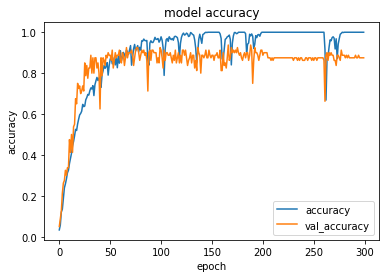

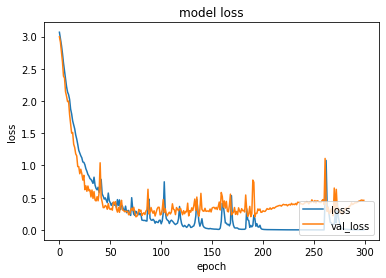

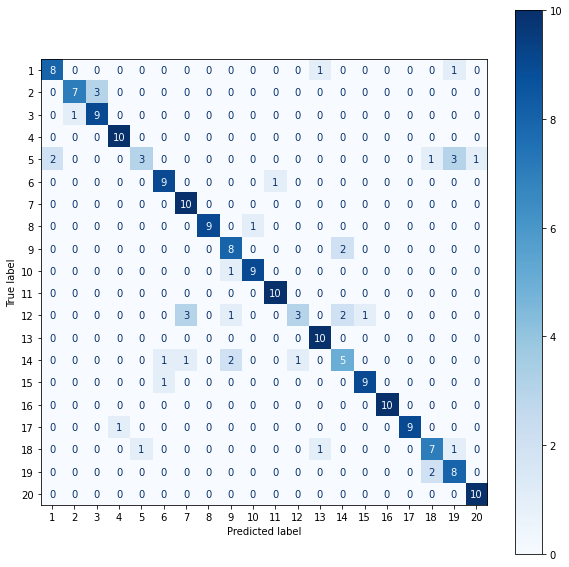

fold 1 score: [1.5327637195587158, 0.7900000214576721]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.75      0.90      0.82        10
           2       0.82      0.90      0.86        10
           3       0.88      0.70      0.78        10
           4       0.90      0.90      0.90        10
           5       0.75      0.60      0.67        10
           6       0.67      0.60      0.63        10
           7       0.75      0.30      0.43        10
           8       0.75      0.90      0.82        10
           9       0.70      0.70      0.70        10
          10       0.75      0.90      0.82        10
          11       0.82      0.90      0.86        10
          12       0.86      0.60      0.71        10
          13       0.82      0.90      0.86        10
          14       0.73      0.80      0.76        10
          15       0.83      1.00      0.91        10
          16       0.82      0.90      0.86        10
          17       0.90      0.90      0.90        10
          18       0.58    

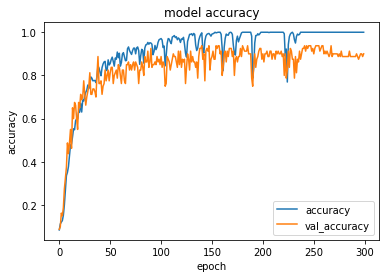

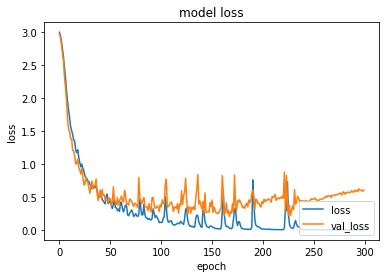

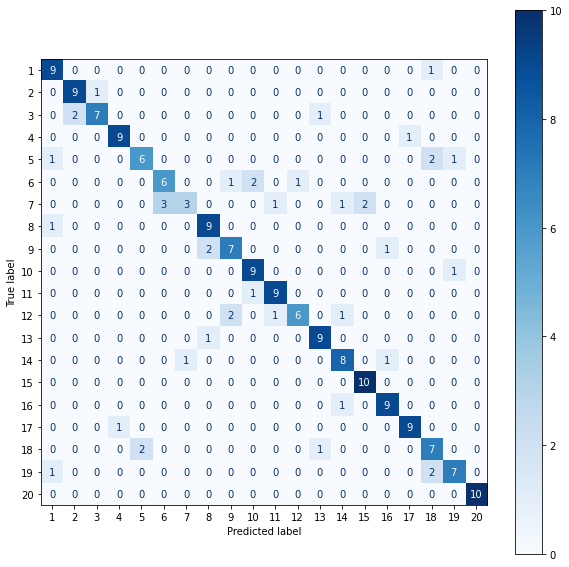

fold 2 score: [1.1465086936950684, 0.8149999976158142]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       1.00      0.60      0.75        10
           3       0.64      0.90      0.75        10
           4       1.00      0.70      0.82        10
           5       1.00      0.20      0.33        10
           6       0.91      1.00      0.95        10
           7       0.67      0.80      0.73        10
           8       1.00      0.60      0.75        10
           9       0.82      0.90      0.86        10
          10       0.88      0.70      0.78        10
          11       1.00      0.90      0.95        10
          12       0.70      0.70      0.70        10
          13       0.77      1.00      0.87        10
          14       0.71      0.50      0.59        10
          15       1.00      0.90      0.95        10
          16       0.83      1.00      0.91        10
          17       0.77      1.00      0.87        10
          18       0.62    

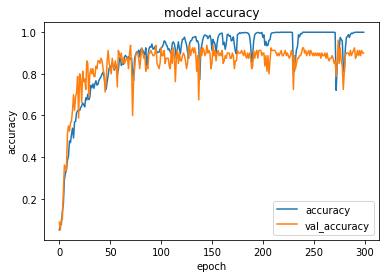

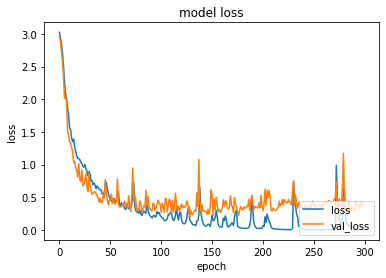

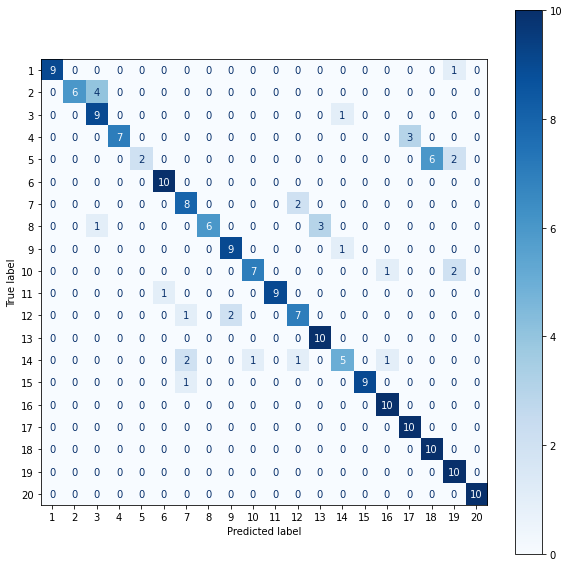

fold 3 score: [0.7952213287353516, 0.824999988079071]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.88      0.70      0.78        10
           2       0.80      0.80      0.80        10
           3       0.80      0.80      0.80        10
           4       1.00      1.00      1.00        10
           5       0.82      0.90      0.86        10
           6       0.83      1.00      0.91        10
           7       0.62      1.00      0.77        10
           8       0.80      0.40      0.53        10
           9       0.67      0.80      0.73        10
          10       0.78      0.70      0.74        10
          11       0.89      0.80      0.84        10
          12       1.00      0.60      0.75        10
          13       0.71      1.00      0.83        10
          14       0.75      0.30      0.43        10
          15       1.00      1.00      1.00        10
          16       0.77      1.00      0.87        10
          17       1.00      1.00      1.00        10
          18       0.83    

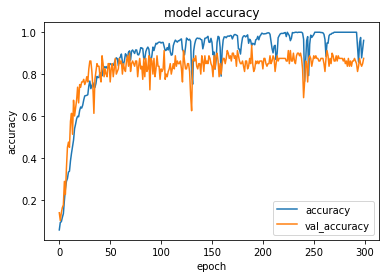

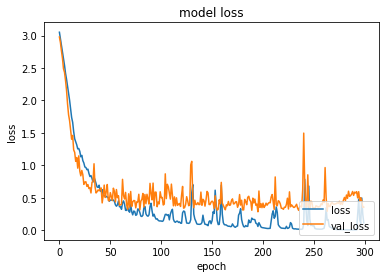

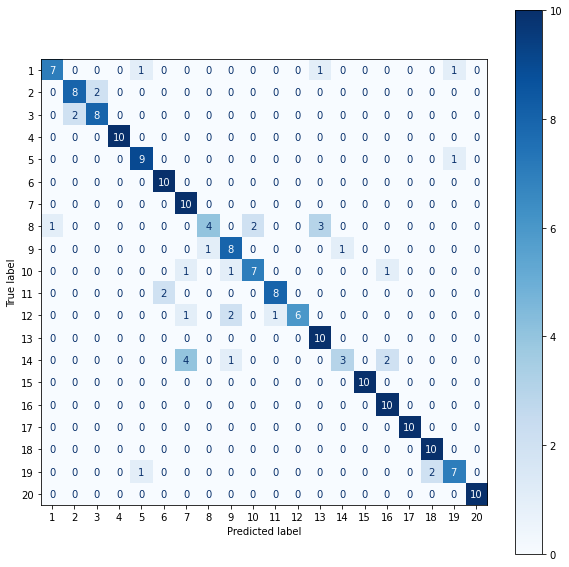

fold 4 score: [1.6510521173477173, 0.7400000095367432]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.36      0.40      0.38        10
           2       0.67      0.80      0.73        10
           3       0.56      0.50      0.53        10
           4       0.89      0.80      0.84        10
           5       0.62      0.50      0.56        10
           6       0.90      0.90      0.90        10
           7       0.78      0.70      0.74        10
           8       0.67      0.60      0.63        10
           9       0.67      0.40      0.50        10
          10       0.62      0.80      0.70        10
          11       0.82      0.90      0.86        10
          12       0.60      0.60      0.60        10
          13       0.82      0.90      0.86        10
          14       0.80      0.80      0.80        10
          15       0.90      0.90      0.90        10
          16       0.90      0.90      0.90        10
          17       0.89      0.80      0.84        10
          18       0.67    

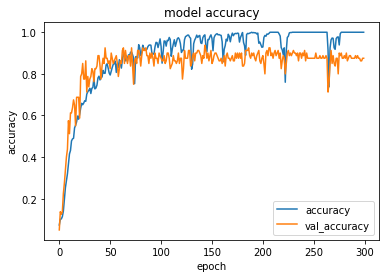

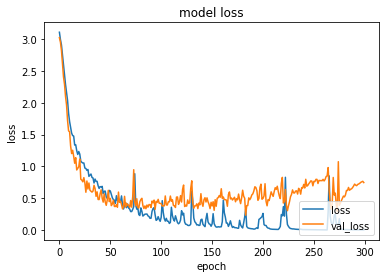

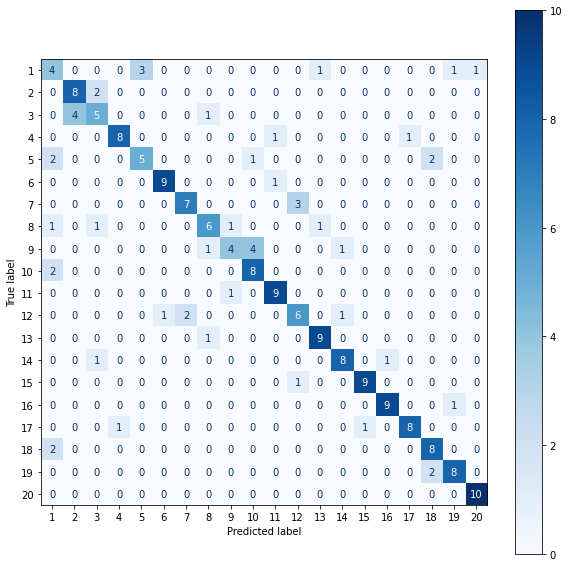

fold 5 score: [0.9753308296203613, 0.7799999713897705]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.86      0.60      0.71        10
           2       0.58      0.70      0.64        10
           3       0.60      0.30      0.40        10
           4       0.91      1.00      0.95        10
           5       0.80      0.80      0.80        10
           6       0.88      0.70      0.78        10
           7       0.89      0.80      0.84        10
           8       0.67      0.60      0.63        10
           9       0.86      0.60      0.71        10
          10       0.91      1.00      0.95        10
          11       0.77      1.00      0.87        10
          12       0.67      0.80      0.73        10
          13       0.77      1.00      0.87        10
          14       0.56      0.50      0.53        10
          15       1.00      1.00      1.00        10
          16       0.91      1.00      0.95        10
          17       0.90      0.90      0.90        10
          18       0.71    

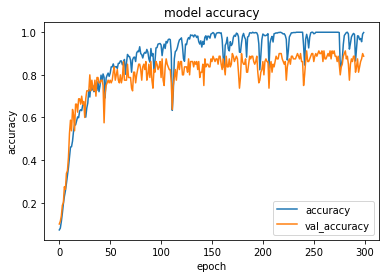

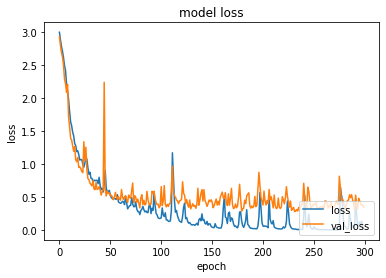

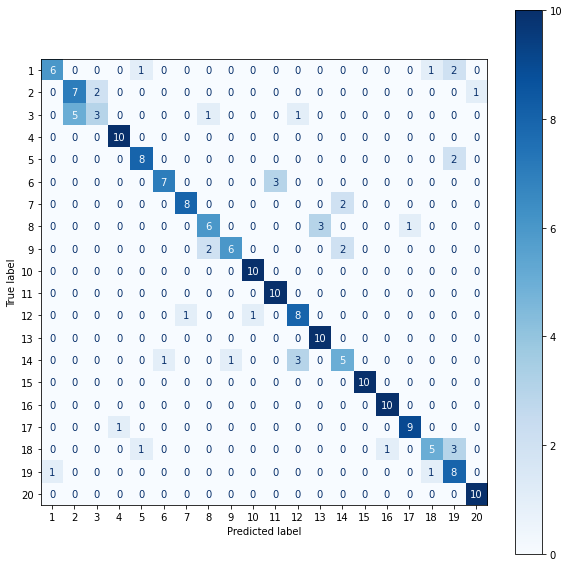

fold 6 score: [1.82340669631958, 0.7749999761581421]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.62      0.50      0.56        10
           2       1.00      0.70      0.82        10
           3       0.54      0.70      0.61        10
           4       0.88      0.70      0.78        10
           5       0.86      0.60      0.71        10
           6       0.90      0.90      0.90        10
           7       1.00      0.80      0.89        10
           8       0.50      0.50      0.50        10
           9       0.62      0.50      0.56        10
          10       0.80      0.80      0.80        10
          11       0.69      0.90      0.78        10
          12       0.80      0.80      0.80        10
          13       0.75      0.90      0.82        10
          14       0.86      0.60      0.71        10
          15       0.90      0.90      0.90        10
          16       0.77      1.00      0.87        10
          17       0.75      0.90      0.82        10
          18       0.69    

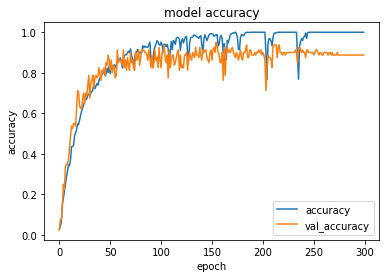

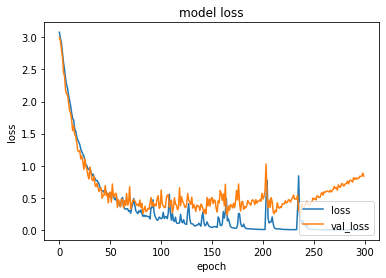

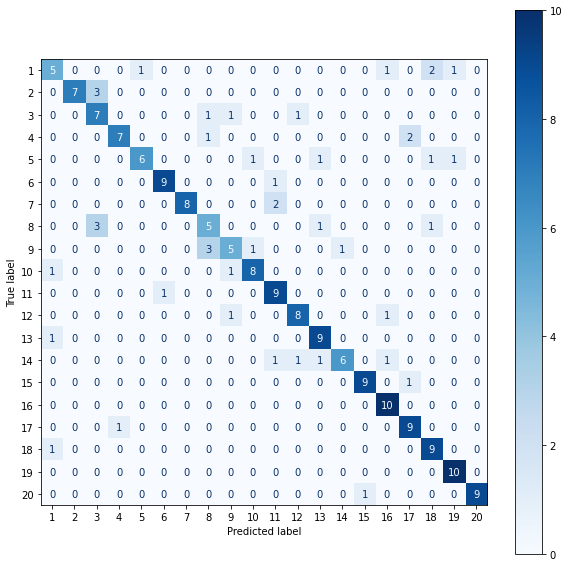

fold 7 score: [1.041164517402649, 0.7950000166893005]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.64      0.70      0.67        10
           2       0.78      0.70      0.74        10
           3       0.75      0.90      0.82        10
           4       0.88      0.70      0.78        10
           5       0.67      0.40      0.50        10
           6       1.00      1.00      1.00        10
           7       0.71      1.00      0.83        10
           8       0.60      0.60      0.60        10
           9       0.75      0.60      0.67        10
          10       0.73      0.80      0.76        10
          11       0.91      1.00      0.95        10
          12       0.83      0.50      0.62        10
          13       0.83      1.00      0.91        10
          14       0.60      0.60      0.60        10
          15       1.00      0.90      0.95        10
          16       0.90      0.90      0.90        10
          17       0.80      0.80      0.80        10
          18       0.67    

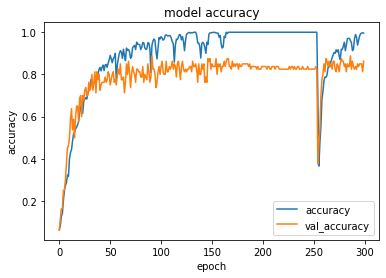

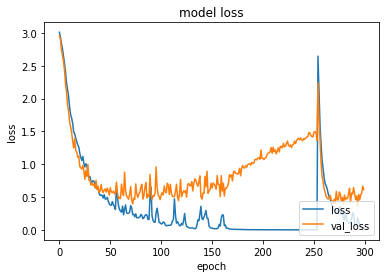

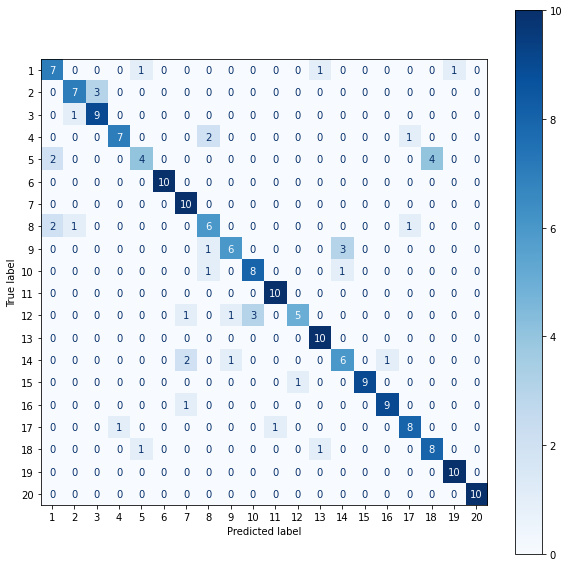

fold 8 score: [0.9227058291435242, 0.8399999737739563]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       1.00      0.80      0.89        10
           2       1.00      0.60      0.75        10
           3       0.64      0.90      0.75        10
           4       0.83      1.00      0.91        10
           5       1.00      0.60      0.75        10
           6       0.91      1.00      0.95        10
           7       0.83      0.50      0.62        10
           8       1.00      0.90      0.95        10
           9       0.78      0.70      0.74        10
          10       0.88      0.70      0.78        10
          11       0.69      0.90      0.78        10
          12       1.00      0.80      0.89        10
          13       0.83      1.00      0.91        10
          14       0.58      0.70      0.64        10
          15       0.83      1.00      0.91        10
          16       0.90      0.90      0.90        10
          17       1.00      0.80      0.89        10
          18       0.91    

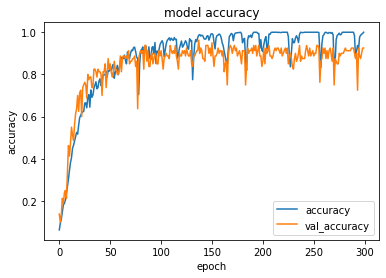

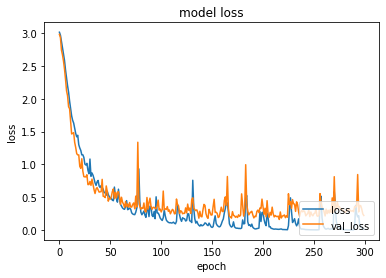

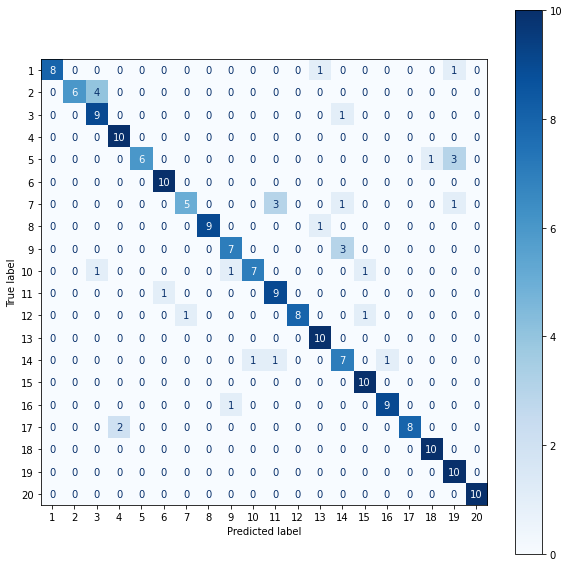

fold 9 score: [0.7016674280166626, 0.7950000166893005]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.54      0.70      0.61        10
           2       0.80      0.80      0.80        10
           3       0.58      0.70      0.64        10
           4       0.71      1.00      0.83        10
           5       0.67      0.40      0.50        10
           6       0.77      1.00      0.87        10
           7       0.77      1.00      0.87        10
           8       0.82      0.90      0.86        10
           9       0.78      0.70      0.74        10
          10       0.90      0.90      0.90        10
          11       1.00      0.80      0.89        10
          12       0.70      0.70      0.70        10
          13       0.90      0.90      0.90        10
          14       0.60      0.60      0.60        10
          15       1.00      0.70      0.82        10
          16       1.00      0.90      0.95        10
          17       1.00      0.60      0.75        10
          18       0.88    

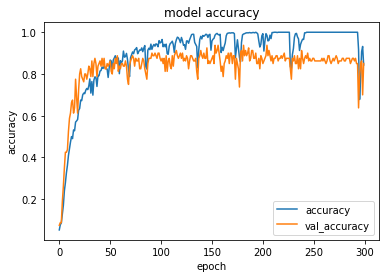

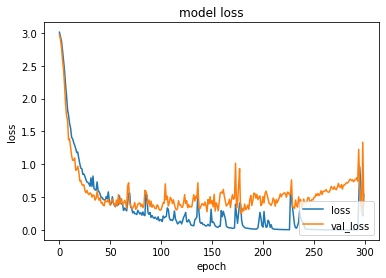

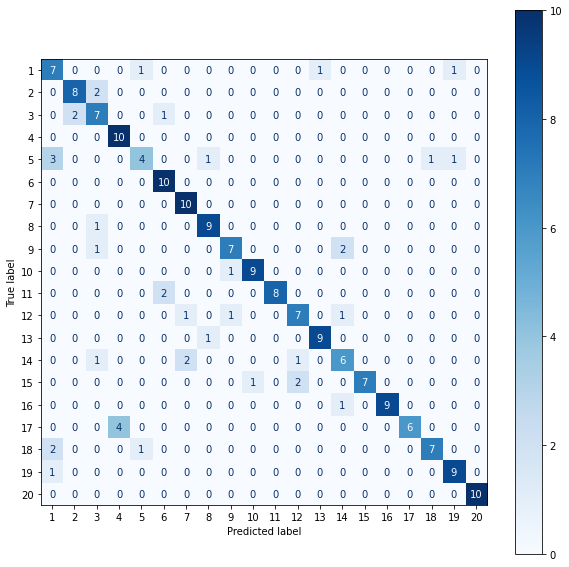

CV score: 0.9743483185768127


In [11]:
FOLD = 10
EPOCH = 300
BATCH_SIZE = 16

valid_scores = []
models = []
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(x_train, Y_train)):
    X_train, X_valid = x_train[train_indices], x_train[valid_indices]
    y_train, y_valid = Y_train[train_indices], Y_train[valid_indices]
    

    X_train = np.array(X_train).reshape(720, 30, 162)
    X_valid = np.array(X_valid).reshape(80, 30,162)
    y_train = np.array(y_train[::30]).reshape(720)
    y_valid = np.array(y_valid[::30]).reshape(80)
    y_train = np_utils.to_categorical(y_train,20)
    y_valid = np_utils.to_categorical(y_valid,20)

    X_train = X_train.astype(np.float)
    X_valid = X_valid.astype(np.float)
    y_train = y_train.astype(np.float)
    y_valid = y_valid.astype(np.float)
    model = build_model(X_train.shape[2])

    rlr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.1,
                            patience=3,
                            verbose=0,
                            min_delta=1e-4,
                            mode='min')
    ckp = ModelCheckpoint(f'model_{fold}.hdf5',
                          monitor='val_loss',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=True,
                          mode='min')
    es = EarlyStopping(monitor='val_loss',
                       min_delta=1e-4,
                       patience=7,
                       mode='min',
                       baseline=None,
                       restore_best_weights=True,
                       verbose=0)

    history=model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              #callbacks=[rlr, ckp, es],
              verbose=0)

    #y_valid_pred = model.predict(X_valid)
    #score = log_loss(y_valid, y_valid_pred)
    score = model.evaluate(X_test,y_test,verbose=0)
    print(f'fold {fold} score: {score}')
    valid_scores.append(score)
    Y_pred = model.predict_generator(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9","10","11","12","13","14","15","16","17", "18", "19", "20"]
    
    report = metrics.classification_report(Y_test,y_pred, 
                                       labels=np.arange(len(labels)),
                                       target_names=labels)
    print(report)
    # 学習履歴をプロット
    plot_history(history)
    cmd_pose(Y_test,y_pred)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')
